In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from itertools import chain
import warnings
from sklearn.utils import resample
import os
import itertools 

import plotly.express as px
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression

# Table of contents
1. [Load data](#loaddata)
    1. [Loading CMU Movie Summary Corpus data and processed NLP summaries](#data)
2. [Data analysis](#dataanalysis)
    1. [Comparison between the mentions of Female and Male in the summary and CMU data](#mentions_summary_CMU)
    2. [Computing few statistics per movies](#statistics)
        1. [Statistics related to words in the summaries](#statistics_words)
        2. [Statistics in different movie genres](#statistics_movie_genre)
    3. [Clustering of recurrent actions ](#clustering)
    4. [Counting and ploting most frequent words](#wordcount)
       


# Load data <a name="loaddata"></a>

## Loading CMU Movie Summary Corpus data and processed NLP summaries <a name="data"></a>

In [31]:
#Load nlp_output and Usa character form metadata
output = pd.read_pickle('data/process.pkl')
usa_charac = pd.read_pickle('data/usa_charac.pkl')
movie_metadata = pd.read_pickle('data/movie_metadata.pkl')

#Separating dataframe based on gender
characters_F = output[output['gender'] == 'F']
characters_M = output[output['gender'] == 'M']

output.sample(10)

,name,mention,release_date,gender,age,active,passive,genres,activeness_score
movie_id,,,,,,,,,
535969,artie,1,1998,M,73.0,[],[],"[Buddy film, Adventure, Children's/Family, Ani...",NaN
2465797,ephialtes,7,2006,M,41.0,"[ask, join, warn, hold, defect, inform]","[meet, turn]","[Historical fiction, Adventure, Superhero movi...",0.750000
284957,tommy,9,1982,M,27.0,"[see, give, stick, get, drop, stick, manage, p...","[belong, ambush, identify]","[Sex comedy, Coming of age, Comedy, Teen]",0.727273
1254881,ben,15,1990,M,NaN,"[join, clear, think, suggest, proceed, begin, ...","[defend, protect, wound]","[Cult, Zombie Film, Satire, Horror, Indie]",0.833333
2071080,redmond,1,1976,M,NaN,[],[],"[Thriller, Action/Adventure, Sports, Drama, Co...",NaN
2425302,brennan,6,2006,M,60.0,"[escort, attempt, bolt, seek, approach, delive...","[send, impale]","[Cult, Demonic child, Horror, Thriller, Supern...",0.800000
7255312,maleva,2,2010,F,65.0,"[suture, refuse]",[],"[Thriller, Horror, Monster movie, Drama, Remake]",1.000000
2158983,doug,5,1995,M,NaN,"[ask, take, abandon, rescue]",[go],"[Parody, Comedy, Domestic Comedy]",0.800000
10411269,sharif,14,1976,M,NaN,"[lie, confirm, have, prepare, find, have, twis...","[rub, get, chain, gag, rape, withhold]","[Indie, Adult, Action/Adventure, Drama, Action...",0.647059


In [32]:
#Define a bootstrap function used for the below analysis
def bootstrap_CI(df:pd.DataFrame, alpha:float=0.95, stat=np.mean, **kwargs):
    """Compute the bootstrap CI of any statistics

        Parameters
        ----------
        df : pd.DataFrame
            sample to bootstrap on
        alpha : float
            percentage of the confidence interval, value between 0 and 1 (default=0.95)
        stat: Callable
            function to compute the statistic (default:np.mean)
        kwargs: 
            argument to pass to the stat function
            
        Return
        ----------
        low: low CI
        high: high CI
        
    """
    
    if kwargs:
        mean_boot = np.array([stat(resample(df, kwargs)) for i in range (10000)])
    else:
        mean_boot = np.array([stat(resample(df)) for i in range (10000)])
        
    mean_boot = np.sort(mean_boot,axis=0)
    
    low = np.percentile(mean_boot, 100*(1-alpha)/2, axis=0)
    high = np.percentile(mean_boot, 100*(alpha+((1-alpha)/2)), axis=0)
    
    return low, high

# Data analysis <a name="dataanalysis"></a>

## Comparison between the mentions of Female and Male in the summary and CMU data <a name="mentions_summary_CMU"></a>

## Does the fraction of mentions for Female vs Male in the summaries the same as in the characters data from the CMU?

In [33]:
#Define function to compute the fraction of female characters in a dataframe
def compute_fraction_f(df):
    nb_total = df['name'].count()
    nb_F = df[df['gender'] == 'F'].name.count()
    
    return nb_F/nb_total

In [34]:
# Overall fraction
fraction_metadata = compute_fraction_f(usa_charac)
fraction_nlp = compute_fraction_f(output)

print('Overall, the fraction of female character in the CMU character metadata is:', "%.5f" % fraction_metadata)
print('While for the characters mentionned in the plot summary, the mean female character fraction is:', "%.5f" % fraction_nlp)

Overall, the fraction of female character in the CMU character metadata is: 0.32436
While for the characters mentionned in the plot summary, the mean female character fraction is: 0.32659


### Evolution of the fraction

In [35]:
#Group data by decades
metadata_decades = usa_charac.groupby((usa_charac.release_date//10)*10)
nlp_decades = output.groupby((output.release_date//10)*10)

#Compute difference of percentage
fraction_metadata = metadata_decades.apply(lambda x: compute_fraction_f(x))
fraction_nlp = nlp_decades.apply(lambda x: compute_fraction_f(x))

#Compute bootstrap 
CI_metadata =  metadata_decades.apply(lambda x : bootstrap_CI(x, stat=compute_fraction_f))
CI_nlp =  nlp_decades.apply(lambda x : bootstrap_CI(x, stat=compute_fraction_f))

CI_metadata_low = [x[0] for x in CI_metadata]
CI_metadata_high = [x[1] for x in CI_metadata]

CI_nlp_low = [x[0] for x in CI_nlp]
CI_nlp_high = [x[1] for x in CI_nlp]

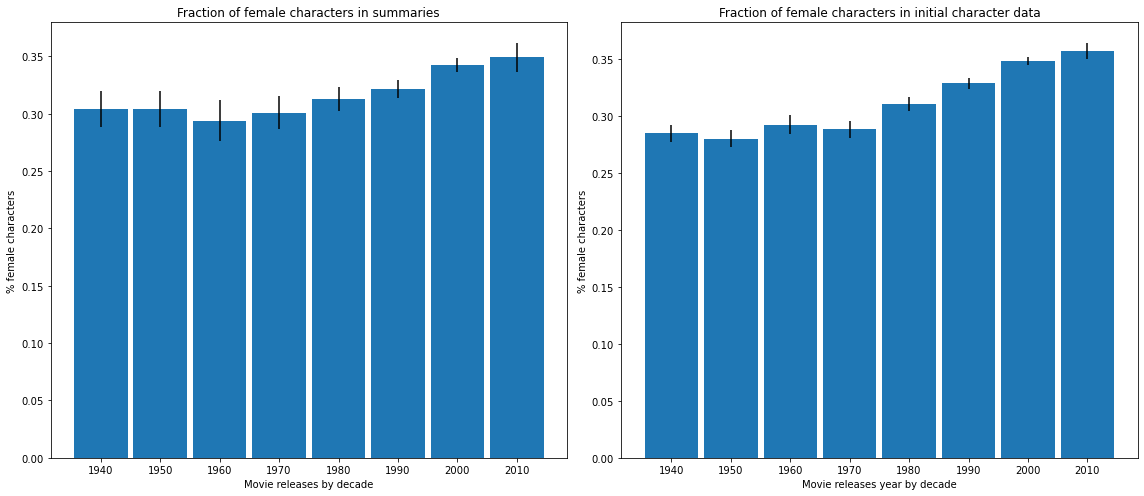

In [36]:
#General distribution of characters depending on gender 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

ax1.bar(np.unique((output.release_date//10)*10), fraction_nlp, width = np.repeat(9, 8), yerr=[(fraction_nlp-CI_nlp_low), (CI_nlp_high-fraction_nlp)])
ax1.set_title('Fraction of female characters in summaries')
ax1.set_xlabel('Movie releases by decade')
ax1.set_ylabel('% female characters')

ax2.bar(np.unique((output.release_date//10)*10), fraction_metadata,  width = np.repeat(9, 8), yerr=[(fraction_metadata-CI_metadata_low), (CI_metadata_high-fraction_metadata)])
ax2.set_title('Fraction of female characters in initial character data')
ax2.set_xlabel('Movie releases year by decade')
ax2.set_ylabel('% female characters')

plt.tight_layout()
plt.show() 

Firstly, we see that overall the mean fraction of female characters in the CMU metadata and the fraction of female characters mentioned is almost equal. Moreover, we observe the same evolution in both fractions as shown in the graph above. Indeed, the fraction of female characters appeared to have increased. In 1940, women represented about *30%* of the characters important enough to be mentioned in the plot summary. This fraction was almost constant until 1980. From then, the percentage slowly rises until reaching about *35*% in 2010. This is consitent with the slow advancement of women's rights since the 80s. Additionaly, this trend seems to be significant as shown by the bootstrap on the plot.

## When would we expect the parity if the increase continues at the same rate ?
To predict when the fraction is expected to reach out parity (i.e both fraction should be equal to 0.5), we fit a linear regression to our data.

In [37]:
#Initializing the argument of the linear regression model 
X = np.array(fraction_nlp.index).reshape(-1, 1)
y = fraction_nlp
reg = LinearRegression().fit(X, y)

print('Prediction for 2232:', float(reg.predict(np.array([[2232]]))))

print('If we assume that the fraction will continue increasing linearly, the parity is expected to happen in 2232.')

Prediction for 2232: 0.5002940579882944
If we assume that the fraction will continue increasing linearly, the parity is expected to happen in 2232.


In [38]:
#function that takes a dataframe as an argument and returns the fraction of female characters 
def compute_fraction_f(df):
    nb_total = df['name'].count()
    nb_F = df[df['gender'] == 'F'].name.count()
    
    return nb_F/nb_total

#Define fraction of FvsM characters
fraction_F = fraction_nlp
fraction_M = 1-fraction_F
fraction = pd.DataFrame({'female': fraction_F, 'male': fraction_M})

#Define linear regression fit line
linear_fit_F = reg.predict(np.array([[1940],[2010],[2232]]))
linear_fit_M = 1- linear_fit_F
linear_fit = pd.DataFrame({'female': linear_fit_F, 'male': linear_fit_M}, index= [1940,2010,2232])

In [39]:
#Making interactive plot
fig = make_subplots(rows=1, cols=1)

#Plot fraction
fig.add_trace(go.Scatter(x=fraction.index, y = fraction.male, mode = 'lines', name= 'male'))
fig.add_trace(go.Scatter(x=fraction.index, y = fraction.female, mode = 'lines', name= 'female'))

#Plot the linear regression until parity
fig.add_trace(go.Scatter(x=linear_fit.index, y = linear_fit.female, mode = 'lines', name= 'female fit', line_dash="dash"))
fig.add_trace(go.Scatter(x=linear_fit.index, y = linear_fit.male, mode = 'lines', name= 'male fit',  line_dash="dash"))

#Add dashed line at fraction 0.5 
fig.add_hline(y=0.5, line_width=1, line_dash="dash")

#Add comment on graph
fig.add_trace(go.Scatter(
    x=[2060, 2160, 2225],
    y=[0.55, 0.6, 0.55],
    mode="text",
    text=["Keep scrolling...", "Almost there!", "Ah! After only 292 years, <br> parity has been acheived. Yeah!"],
    textposition="top center",
    name = ''
))

#Updating the figure 
fig.update_layout(height=500, width=9500, plot_bgcolor =  'whitesmoke', yaxis_title="fraction of characters", xaxis_range=[1940,2235],
                  #title=dict(text='Evolution of the fraction of female and male characters over the years in movies', y=0.87),
                 xaxis = dict(
                    tickmode = 'linear',
                    tick0 = 1940,
                    dtick = 5),
                  legend=dict(
                    yanchor="top",
                    y=0.72,
                    xanchor="left",
                    x=0.001)
                 )

fig.add_annotation(
    x=1965,
    y=0.36,
    xref="x", yref="y",
    text="Scroll this way...",
    axref="x",
    ayref="y",
    showarrow=True,
    ax=1960,
    ay=0.36,
    arrowhead=2,
    arrowwidth=1.5,
)
            
fig.update_traces(textfont_size=14)

fig.show()

#saving the figure as an HTML file
fig.write_html("evolution_fraction_scroll.html")

## Computing few statistics per movies <a name="statistics"></a>

For each movie, we compute the percentage of mentions that are linked to female character and the mean activeness score (i.e number of active verbs over total number of verbs) of women and men.

In [40]:
#Compute per movie the % mentions are from women 
mentions_movie = output.groupby('movie_id').apply(lambda x: x.mention.sum())
F_mentions_movie = characters_F.groupby('movie_id').apply(lambda x: x.mention.sum())

perc_f_mentions = F_mentions_movie/mentions_movie

#Compute mean "activeness" score per movie
F_mean_score = characters_F.groupby('movie_id').apply(lambda x: x.activeness_score.mean())
M_mean_score = characters_M.groupby('movie_id').apply(lambda x: x.activeness_score.mean())

#Define dataframe containing all info
stat_per_movie = pd.DataFrame({'F_mentions': perc_f_mentions, 'F_score': F_mean_score, 'M_score': M_mean_score})
stat_per_movie['release_date'] = movie_metadata.loc[stat_per_movie.index].release_date
stat_per_movie['genres'] = movie_metadata.loc[stat_per_movie.index].genres

stat_per_movie

,F_mentions,F_score,M_score,release_date,genres
movie_id,,,,,
3217,0.106383,0.000000,0.000000,1992,"[Cult, Horror, Stop motion, Costume drama, Act..."
3746,0.262136,0.498538,0.589418,1982,"[Thriller, Cyberpunk, Science Fiction, Future ..."
3837,0.040816,0.000000,0.759390,1974,"[Western, Satire, Comedy]"
3947,0.317241,0.671922,0.783859,1986,"[Thriller, Mystery, Crime Fiction]"
4227,0.120690,0.750000,0.598799,1975,"[Costume drama, Film adaptation, Period piece,..."
...,...,...,...,...,...
36354703,1.000000,0.521245,NaN,1992,[Comedy film]
36500436,0.244444,0.562500,0.414394,2012,"[Science Fiction, Drama]"
36544941,0.138889,0.916667,0.760000,2011,"[Drama, Comedy]"


## Are women as much mentionned in the plot summaries?

We have seen that women account for about one third of the characters mentionned in the plot summaries. However, do they have as many important roles as their male counterpart? Indeed, one can see the number of mentions of a character in the plot summary as a proxy for their importance. Intituvely, someone that is mentionned numerous times in the summary should be more central to the plotline than a character only mentioned once or twice. Nonetheless, note that this measure is not perfect and biased.

In [41]:
#Overall fraction 
F_mentions_mean = compute_fraction_f(usa_charac)

print('Overall, the fraction of mentions in the plot summary linked to female characters is:', "%.5f" % F_mentions_mean)

Overall, the fraction of mentions in the plot summary linked to female characters is: 0.32436


### Evolution of the proportion of mentions

In [42]:
#Compute mean %F mentions per decades
F_mentions_mean = stat_per_movie.groupby((stat_per_movie.release_date//10)*10).F_mentions.mean()

#Compute bootstrap CI of mean %F mentions
CI = stat_per_movie.groupby((stat_per_movie.release_date//10)*10).F_mentions.apply(lambda x : bootstrap_CI(x, stat=np.mean))
CI_low = [x[0] for x in CI]
CI_high = [x[1] for x in CI]

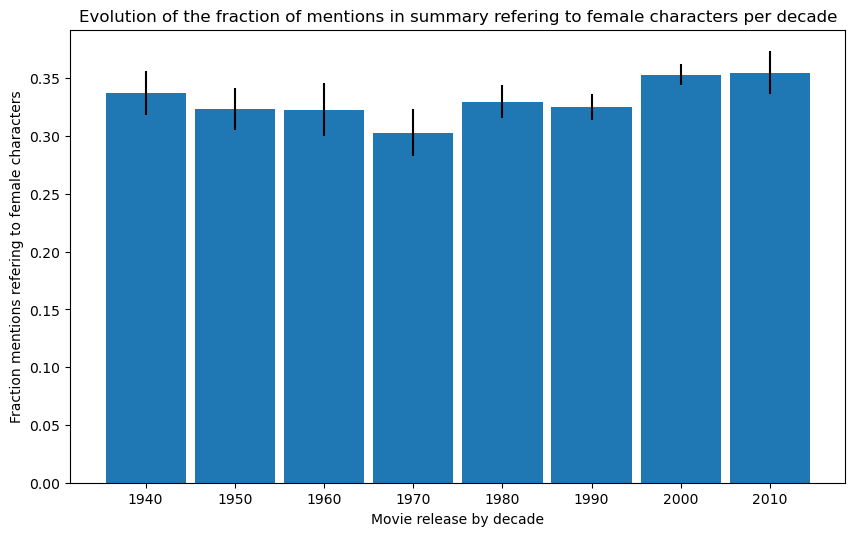

In [43]:
fig = plt.figure(figsize = (10,6), dpi = 100)

#ploting the barplot
plt.bar(np.unique((output.release_date//10)*10), F_mentions_mean,  width = np.repeat(9, 8), yerr=[(F_mentions_mean-CI_low), (CI_high-F_mentions_mean)])
plt.title('Evolution of the fraction of mentions in summary refering to female characters per decade')
plt.xlabel('Movie release by decade')
plt.ylabel('Fraction mentions refering to female characters')
plt.show()

Overall, the fraction of mentions in the plot summary that are linked to female characters is about *32%* which is very similar to the fraction of female characters(, which is also about *32*%). Here we observe a sightly different trend, it decreases slowly until the 70s from *33*% to *30*%, then increases until reaching *35*% in the 2010. However, it appears that this small decrease and increase is not significant as indicated by the CI on the barplots.

Therefore, we conclude that no real increase in the number of major female characters in movies have been observed.

## Do female character have an active score similar to their male conterpart?

We use bootstrap to see if this difference is significant. Overall, it seems that women are portrayed doing active actions slightly less than men. However, the magnitude of the difference is very small. Therefore, we do not observe any meanigful difference here. Moreover, when computing this metric in each decade, we see that the difference is not always significant.

In [44]:
#function that takes a dataframe as an argumnent and return the difference between mean activeness score of male and female
def compute_diff_score(df):
    
    #Compute score, then take difference
    F_mean = df[df['gender'] == 'F']['activeness_score'].mean()
    M_mean = df[df['gender'] == 'M']['activeness_score'].mean()
    diff = M_mean - F_mean
    
    return diff

In [ ]:
#Compute the mean overall score for F and M characters
diff = compute_diff_score(output)

#Compute bootstrap interval of the difference
CI_diff_low, CI_diff_high = bootstrap_CI(output, alpha=0.95, stat=compute_diff_score)

#Plot the diff with its CI
plt.bar(['Fraction of active over total verbs'], [diff], yerr=[[diff-CI_diff_low], [CI_diff_high-diff]])
plt.title('Difference in fraction of active over total verbs of male and female characters')
plt.ylabel('Difference between F vs M activeness')
plt.show()

### Has this evolved over the years?

In [ ]:
#Group the dataframe by year
by_decade = output.groupby((output.release_date//10)*10)

#Compute the mean overall score for F and M characters by year
diff = by_decade.apply(lambda x: compute_diff_score(x))

#Compute bootstrap interval of the ratio+differences
CI = by_decade.apply(lambda x: bootstrap_CI(x, alpha=0.95, stat=compute_diff_score))
CI_low = [x[0] for x in CI]
CI_high = [x[1] for x in CI]

#Plot the diff with its CI
plt.bar(np.unique((output.release_date//10)*10), diff, yerr=[diff-CI_low, CI_high-diff], width=np.repeat(9,8))
plt.title('Evolution difference in fraction of active over total verbs of male and female characters')
plt.ylabel('Difference between activeness score of M vs F characters')
plt.show()

### Statistics related to words in the summaries <a name="statistics_words"></a>

### But what do these characters actually do?
Let's look at the most frequent active/passive verbs for both gender overall.

In [ ]:

def get_count_verbs(df, name:str):
    verbs, count = np.unique(list((chain(*list(df[name])))), return_counts=True)
    
    return pd.DataFrame({name: verbs, 'occurence': count}).sort_values(by=['occurence'], ascending=False)

    
#Investigate in all movies, overall
active_F = get_count_verbs(characters_F, 'active')
active_M = get_count_verbs(characters_M, 'active')

passive_F = get_count_verbs(characters_F, 'passive')
passive_M = get_count_verbs(characters_M, 'passive')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 15))

ax1.barh(active_F.iloc[0:100].active, active_F.iloc[0:100].occurence)
ax1.set_xlabel('# mentions of verbs')
ax1.set_title('Barplot of the #of mentions of active verbs for women')

ax2.barh(active_M.iloc[0:100].active, active_M.iloc[0:100].occurence)
ax2.set_xlabel('# mentions of verbs')
ax2.set_title('Barplot of the #of mentions of active verbs for men')

plt.tight_layout()
plt.show() 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 15))

ax1.barh(passive_F.iloc[0:100].passive, passive_F.iloc[0:100].occurence)
ax1.set_xlabel('# mentions of verbs')
ax1.set_ylabel('genres')
ax1.set_title('Barplot of the # of mentions of passive verbs for women')

ax2.barh(passive_M.iloc[0:100].passive, passive_M.iloc[0:100].occurence)
ax2.set_xlabel('# mentions of verbs')
ax2.set_title('Barplot of the # of mentions of passive verbs for men')

plt.tight_layout()
plt.show() 

## Do the verbs change overtime?

In [ ]:
#Group the characters by decades
F_active_by_decades = characters_F.groupby((characters_F.release_date//10)*10).apply(lambda x: get_count_verbs(x, 'active'))
M_active_by_decades = characters_M.groupby((characters_M.release_date//10)*10).apply(lambda x: get_count_verbs(x, 'active'))
F_passive_by_decades = characters_F.groupby((characters_F.release_date//10)*10).apply(lambda x: get_count_verbs(x, 'passive'))
M_passive_by_decades = characters_M.groupby((characters_M.release_date//10)*10).apply(lambda x: get_count_verbs(x, 'passive'))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 30))

ax1.barh(F_active_by_decades.loc[1950].iloc[0:100].active, F_active_by_decades.loc[1950].iloc[0:100].occurence)
ax1.set_xlabel('# mentions of verbs')
ax1.set_ylabel('genres')
ax1.set_title('Barplot of the # of mentions of active verbs for women')

ax2.barh(M_active_by_decades.loc[1950].iloc[0:100].active, M_active_by_decades.loc[1950].iloc[0:100].occurence)
ax2.set_xlabel('# mentions of verbs')
ax2.set_title('Barplot of the # of mentions of active verbs for men')

plt.tight_layout()
plt.show() 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 30))

ax1.barh(F_passive_by_decades.loc[1950].iloc[0:100].passive, F_passive_by_decades.loc[1950].iloc[0:100].occurence)
ax1.set_xlabel('# mentions of verbs')
ax1.set_ylabel('genres')
ax1.set_title('Barplot of the # of movies by genres CMU data')

ax2.barh(M_passive_by_decades.loc[1950].iloc[0:100].passive, M_passive_by_decades.loc[1950].iloc[0:100].occurence)
ax2.set_xlabel('# mentions of verbs')
ax2.set_title('Barplot of the # of mentions of passive verbs for men')

plt.tight_layout()
plt.show() 

### Clustering of recurrent actions <a name="clustering"></a>

First, we manually define clusters of words present in the top 100 occuring verbs, that are present in the different categories (Female, Male, active, passive). We noticed that a lot of verbs were associated with violent actions (attack, stab), romantic relashionships (marry, seduce,...), power (protect, lead, save, ..), and expected stereotypical words related to women (sacrifice, share, need, ...). 

In [ ]:
#Load manual clusters of verbs
manual_clusters = pd.read_excel('data/clusters.xlsx', sheet_name=['passive_violence','active_violence','love','power','exp_woman'], header=None)
passive_violence = np.unique(manual_clusters.get('passive_violence')); active_violence = np.unique(manual_clusters.get('active_violence'))
love = np.unique(manual_clusters.get('love')); power = np.unique(manual_clusters.get('power')); exp_woman = np.unique(manual_clusters.get('exp_woman'))

#Extract top 100 verbs 
top_overall_active_F = active_F.iloc[0:100].reset_index(drop=True)
top_overall_active_M = active_M.iloc[0:100].reset_index(drop=True)
top_overall_passive_F = passive_F.iloc[0:100].reset_index(drop=True)
top_overall_passive_M = passive_M.iloc[0:100].reset_index(drop=True)

#Define function computing fraction and sum of inverse rank in given category
def clusters_words(top_verb:list, cluster_words:list):
    #Get verbs in list
    verbs = [((x,top_verb.iloc[i,1]), 100 -i ) for i, x in enumerate(top_verb.iloc[:,0]) if x in cluster_words]
    
    #Compute number of verbs, get sum inverse rank
    nb_verb = len(verbs)
    inverse_rank = np.sum([x[1] for x in verbs])
    verbs = [x[0] for x in verbs]
    
    return pd.DataFrame({'verb': [verbs], 'nb_verbs': nb_verb, 'score': inverse_rank})

#Type clusters
clusters = ['violence', 'love', 'power', 'exp_woman']

#Compute for each category in overall
active_F_overall = pd.concat([clusters_words(top_overall_active_F, active_violence), clusters_words(top_overall_active_F, love), 
 clusters_words(top_overall_active_F, power), clusters_words(top_overall_active_F, exp_woman)])
active_F_overall.index = clusters
active_M_overall = pd.concat([clusters_words(top_overall_active_M, active_violence), clusters_words(top_overall_active_M, love), 
 clusters_words(top_overall_active_M, power), clusters_words(top_overall_active_M, exp_woman)])
active_M_overall.index = clusters

passive_F_overall = pd.concat([clusters_words(top_overall_passive_F, passive_violence), clusters_words(top_overall_passive_F, love), 
 clusters_words(top_overall_passive_F, power), clusters_words(top_overall_passive_F, exp_woman)])
passive_F_overall.index = clusters
passive_M_overall = pd.concat([clusters_words(top_overall_passive_M, passive_violence), clusters_words(top_overall_passive_M, love), 
 clusters_words(top_overall_passive_M, power), clusters_words(top_overall_passive_M, exp_woman)])
passive_M_overall.index = clusters

In [ ]:
active_F_overall

In [ ]:
passive_M_overall

## Has the most reoccuring actions of male and female characters change overtime?
To investigate this evolution, we split the data in two time period (1940 to 1980 and 1980 to 2014). We only splitted the data in two since if it was splitted in more part we might have insufissant verbs. 

In [ ]:
#Split into two time period
early_F = output[np.logical_and(output['release_date'] < 1980, output['gender'] == 'F')]
early_M = output[np.logical_and(output['release_date'] < 1980, output['gender'] == 'M')]

late_F = output[np.logical_and(output['release_date'] < 1980, output['gender'] == 'F')]
late_M = output[np.logical_and(output['release_date'] < 1980, output['gender'] == 'M')]

#Compute occurence of active/passive verbs
active_F_early = get_count_verbs(early_F, 'active').iloc[0:100].reset_index(drop=True)
active_M_early = get_count_verbs(early_M, 'active').iloc[0:100].reset_index(drop=True)
passive_F_early = get_count_verbs(early_F, 'passive').iloc[0:100].reset_index(drop=True)
passive_M_early = get_count_verbs(early_M, 'passive').iloc[0:100].reset_index(drop=True)

active_F_late = get_count_verbs(late_F, 'active').iloc[0:100].reset_index(drop=True)
active_M_late = get_count_verbs(late_M, 'active').iloc[0:100].reset_index(drop=True)
passive_F_late = get_count_verbs(late_F, 'passive').iloc[0:100].reset_index(drop=True)
passive_M_late = get_count_verbs(late_M, 'passive').iloc[0:100].reset_index(drop=True)

In [ ]:
#Compute for each category in early time period
active_F_early = pd.concat([clusters_words(active_F_early, active_violence), clusters_words(active_F_early, love), 
 clusters_words(active_F_early, power), clusters_words(active_F_early, exp_woman)])
active_F_early.index = clusters
active_M_early = pd.concat([clusters_words(active_M_early, active_violence), clusters_words(active_M_early, love), 
 clusters_words(active_M_early, power), clusters_words(active_M_early, exp_woman)])
active_M_early.index = clusters

passive_F_early = pd.concat([clusters_words(passive_F_early, passive_violence), clusters_words(passive_F_early, love), 
 clusters_words(passive_F_early, power), clusters_words(passive_F_early, exp_woman)])
passive_F_early.index = clusters
passive_M_early = pd.concat([clusters_words(passive_M_early, passive_violence), clusters_words(passive_M_early, love), 
 clusters_words(passive_M_early, power), clusters_words(passive_M_early, exp_woman)])
passive_M_early.index = clusters

#Compute for each category in late time period
active_F_late = pd.concat([clusters_words(active_F_late, active_violence), clusters_words(active_F_late, love), 
 clusters_words(active_F_late, power), clusters_words(active_F_late, exp_woman)])
active_F_late.index = clusters
active_M_late = pd.concat([clusters_words(active_M_late, active_violence), clusters_words(active_M_late, love), 
 clusters_words(active_M_late, power), clusters_words(active_M_late, exp_woman)])
active_M_late.index = clusters

passive_F_late = pd.concat([clusters_words(passive_F_late, passive_violence), clusters_words(passive_F_late, love), 
 clusters_words(passive_F_late, power), clusters_words(passive_F_late, exp_woman)])
passive_F_late.index = clusters
passive_M_late = pd.concat([clusters_words(passive_M_late, passive_violence), clusters_words(passive_M_late, love), 
 clusters_words(passive_M_late, power), clusters_words(passive_M_late, exp_woman)])
passive_M_late.index = clusters

In [ ]:
passive_F_late

In [ ]:
passive_M_early

# Do we observe the same trends in different movie genres?

### Distribution of number of Female vs Male characters in a few genres

In [ ]:
#Selection of genres we want to focus on 
genres_interest = ['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'Horror', 'Adventure', 'Action/Adventure', 'Family Film', 'Musical', 'Animation', 'Science Fiction', 'Fantasy']

for genre in genres_interest:
    mask_F_genre = characters_F.genres.apply(lambda x: genre in x)
    charac_F = characters_F[mask_F_genre]
    
    mask_M_genre = characters_M.genres.apply(lambda x: genre in x)
    charac_M = characters_M[mask_M_genre]
    
    #Rank active/passive verbs by count
    active_F = get_count_verbs(charac_F, 'active')
    active_M = get_count_verbs(charac_M, 'active')

    passive_F = get_count_verbs(charac_F, 'passive')
    passive_M = get_count_verbs(charac_M, 'passive')
    
    #Plot the top 100 verbs of all categories
    #Active
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 30))

    ax1.barh(active_F.iloc[0:100].active, active_F.iloc[0:100].occurence)
    ax1.set_xlabel('# occurence of verbs')
    ax1.set_ylabel('verbs')
    ax1.set_title('Barplot of the # occurence of active verbs for female characters in ' + genre)

    ax2.barh(active_M.iloc[0:100].active, active_M.iloc[0:100].occurence)
    ax2.set_xlabel('# occurence of verbs')
    ax2.set_title('Barplot of the # occurence of active verbs for male characters in ' + genre)
    
    plt.tight_layout()
    plt.show() 
    
    #Passive
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 30))

    ax1.barh(passive_F.iloc[0:100].passive, passive_F.iloc[0:100].occurence)
    ax1.set_xlabel('# occurence of passive verbs')
    ax1.set_ylabel('verbs')
    ax1.set_title('Barplot of the # occurence of passive verbs for female characters in ' + genre)

    ax2.barh(passive_M.iloc[0:100].passive, passive_M.iloc[0:100].occurence)
    ax2.set_xlabel('# occurence of passive verbs')
    ax2.set_title('Barplot of the # occurence of passive verbs for male characters in ' + genre)

    plt.tight_layout()
    plt.show() 

## Same analysis is performed by genres

In [ ]:
#
def mean_by_genre(stat_per_movie, genre) :
    """Compute the bootstrap CI of any statistics

        Parameters
        ----------
        stat_per_movie : pd.DataFrame
            dataframe with statistical infos by genre
        genre : string
            genre
            
        Return
        ----------
        mean of female mentions in a movie genre
        
    """
    mask_F_genre = stat_per_movie.genres.apply(lambda x: genre in x)
    return stat_per_movie[mask_F_genre].F_mentions.mean()

df_F_mentions_by_year = pd.DataFrame({'genre' : genres_interest})

df_F_mentions_by_year['mean_F_mentions'] = df_F_mentions_by_year.genre.apply(lambda genre : mean_by_genre(stat_per_movie, genre))

In [ ]:
# order df decreasing values
df_F_mentions_by_year = df_F_mentions_by_year.sort_values(by=['mean_F_mentions'], ascending = False)

plt.figure(figsize=(6, 6), dpi=80)

plt.barh(df_F_mentions_by_year['genre'], df_F_mentions_by_year['mean_F_mentions'])
plt.xlabel('percentage'); 
plt.title('female mentions by genre ')
plt.show()

We can observe that the percentage of women mentions is the highest in romance film. Often, boys meet girls, fall in love, break up, find new love and everything has a happy ending. 

Interestingly, the second highest movie genre based on women mentions is horror. This might seem initially surprising, nevertheless, often women appear as the damsel in distress and they are usually attacked, abused or violated by a killer. Similarly, among the first positions we can also find thriller. 

Next, among the first movie genres where women have a high percentage of mentions there are musical, drama and comedy. In these kinds of movies, women are also often stereotyped and take part in the story as the girlfriends of a male character.

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25,25))
axes = axes.flatten()

for i, year in enumerate(np.unique(stat_per_movie.release_date//5*5)) :
    
    start_ = year
    end_ = year + 5
    
    # create dataframe with movies between years start and end 
    stat_per_movie_5_years = stat_per_movie[stat_per_movie['release_date'].between(start_, end_)]
    df_F_mentions_by_year = pd.DataFrame({'genre' : genres_interest})
    # create a new df with mean female mentions 5 years by 5 years
    df_F_mentions_by_year['mean_F_mentions'] = df_F_mentions_by_year.genre.apply(lambda genre : mean_by_genre(stat_per_movie_5_years, genre))
    
    #print(df_F_mentions_by_year['mean_F_mentions'].sort_values(axis = 0, ascending = False))
    df_F_mentions_by_year = df_F_mentions_by_year.sort_values(by=['mean_F_mentions'], ascending = False)
    
    axes[i].barh(df_F_mentions_by_year['genre'], df_F_mentions_by_year['mean_F_mentions'])
    axes[i].set_title(str(year) + ' - ' + str(year+5) +  ' : percentage female mentions')

fig.delaxes(axes[15])
plt.tight_layout()
plt.show()    

Overtime we can observe that similarly to the plot above where all mentions between 1940 and 2010 were considered, movie genres occupying the top positions are almost always romance film, musical, drama, comedy, horror, thriller and family film.  

## Counting and ploting most frequent words <a name="wordcount"></a>

In order to visually see the more frequent words, we plotted word clouds with the most frequent words extracted after the clustering of recurrent actions. Three main different situations where analyzed : our initial period data which is between 1940 and 2010 and both periods before and after 1980. (over all the time period data come from (from 1940 to 2010), in the period before 1980 and after 1980. )

In [ ]:
#Convert into list with repetition of verbs for word cloud
def format_word_cloud(df):
    verbs = list(chain(*df.verb))
    verbs = list(chain(*[np.repeat(x[0],x[1]) for x in verbs]))
    
    return verbs

#list with the selected verbs from the plot summarry 
active_F_overall = format_word_cloud(active_F_overall)
active_M_overall = format_word_cloud(active_M_overall)
passive_F_overall = format_word_cloud(passive_F_overall)
passive_M_overall = format_word_cloud(passive_M_overall)

active_F_early = format_word_cloud(active_F_early)
active_M_early = format_word_cloud(active_M_early)
passive_F_early = format_word_cloud(passive_F_early)
passive_M_early = format_word_cloud(passive_M_early)

active_F_late = format_word_cloud(active_F_late)
active_M_late = format_word_cloud(active_M_late)
passive_F_late = format_word_cloud(passive_F_late)
passive_M_late = format_word_cloud(passive_M_late)

In [ ]:
#fuction that takes as an argument a list of words and returns a wordcloud object which is necessary to represent the word plots 
def generate_wordcloud(list_words) : 
    comment_words = ''
    stopwords = set(STOPWORDS)
    

    for val in list_words:

        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "
    wc = WordCloud(background_color = "white", max_words=43, max_font_size=50, stopwords = STOPWORDS,
                   random_state=1,height=300,width=300, collocations=False).generate(comment_words)    
    return wc

#### Active and passive verbs between 1940 and 2010

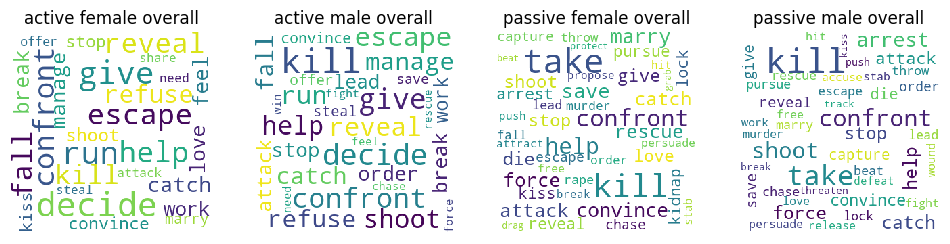

In [53]:
fig, ax = plt.subplot_mosaic([['active_F_overall', 'active_M_overall', 'passive_F_overall', 'passive_M_overall']], figsize=(12, 3.5))

ax['active_F_overall'].imshow(generate_wordcloud(active_F_overall), interpolation = "None")
ax['active_F_overall'].axis('off')  # clear x-axis and y-axis
ax['active_F_overall'].set_title('active female between 1940 and 2010')

ax['active_M_overall'].imshow(generate_wordcloud(active_M_overall), interpolation = "None")
ax['active_M_overall'].axis('off')
ax['active_M_overall'].set_title('active male between 1940 and 2010')

ax['passive_F_overall'].imshow(generate_wordcloud(passive_F_overall), interpolation = "None")
ax['passive_F_overall'].axis('off')
ax['passive_F_overall'].set_title('passive female between 1940 and 2010')

ax['passive_M_overall'].imshow(generate_wordcloud(passive_M_overall), interpolation = "None")
ax['passive_M_overall'].axis('off')
ax['passive_M_overall'].set_title('passive male between 1940 and 2010')

plt.show()

#### Active and passive verbs before 1980

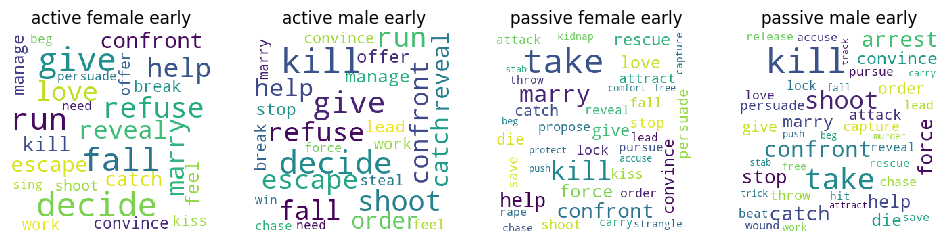

In [50]:
fig, ax = plt.subplot_mosaic([['active_F', 'active_M', 'passive_F', 'passive_M']], figsize=(12, 3.5))

ax['active_F'].imshow(generate_wordcloud(active_F_early), interpolation = "None")
ax['active_F'].axis('off')  # clear x-axis and y-axis
ax['active_F'].set_title('active female before 1980')

ax['active_M'].imshow(generate_wordcloud(active_M_early), interpolation = "None")
ax['active_M'].axis('off')
ax['active_M'].set_title('active male before 1980')

ax['passive_F'].imshow(generate_wordcloud(passive_F_early), interpolation = "None")
ax['passive_F'].axis('off')
ax['passive_F'].set_title('passive female before 1980')

ax['passive_M'].imshow(generate_wordcloud(passive_M_early), interpolation = "None")
ax['passive_M'].axis('off')
ax['passive_M'].set_title('passive male before 1980')

plt.show()

#### Active and passive verbs after 1980

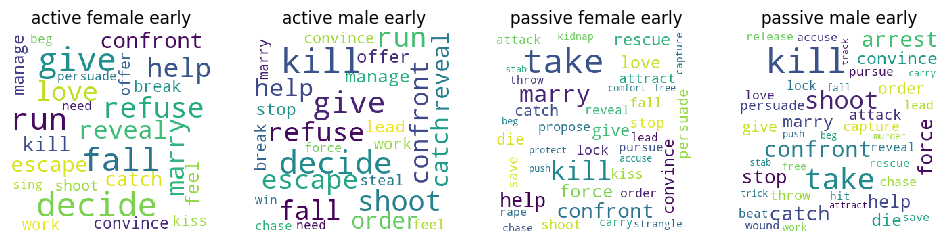

In [52]:
fig, ax = plt.subplot_mosaic([['active_F', 'active_M', 'passive_F', 'passive_M']], figsize=(12, 3.5))

ax['active_F'].imshow(generate_wordcloud(active_F_late), interpolation = "None")
ax['active_F'].axis('off')  # clear x-axis and y-axis
ax['active_F'].set_title('active female after 1980')

ax['active_M'].imshow(generate_wordcloud(active_M_late), interpolation = "None")
ax['active_M'].axis('off')
ax['active_M'].set_title('active male after 1980')

ax['passive_F'].imshow(generate_wordcloud(passive_F_late), interpolation = "None")
ax['passive_F'].axis('off')
ax['passive_F'].set_title('passive female after 1980')

ax['passive_M'].imshow(generate_wordcloud(passive_M_late), interpolation = "None")
ax['passive_M'].axis('off')
ax['passive_M'].set_title('passive male after 1980')

plt.show()

There are verbs appearing in both female and male characters, as both active and passive verbs. Interestingly, it is possible to observe, as an active verb, kill is one of the most frequently employed verb for male characters. This might suggest that male characters tend to be more violent than female characters. Additionally, two verbs related to the cluster of love appear in active female verbs. The first one is marry, this seems to suggest female are more referred as the character involved in weddings. Even if, both male and female are involved in a wedding, this representation gives the impression that women are the figure associated with marriage. The second verb is fall. Even though, the meaning of this verb is not directly related to the topic of love, we supposed that this term might frequently be used as fall in love. This suggest that the stereotypical idea of falling in love is closely linked to female characters. 